# Clear-sky detection

    1) compute kt = I/Iclr  (Ineicheon model)  7:00-17:00 or theta <= 85deg
    2) 1 day = 40 points of kt 
    3) if majority of 40 points of kt >= THRESHOLD --> regard as clear-sky day  --> output = tentative clear-sky days 
    4) compute cosine similarity between Iclr and candidates in 3) 
    5) rank these cosine similarity scores ---> plot the XX best ones using visualization as complimentary
    6) group all those XX best ones (assume these XX ones are quite large and cover many stations) into each stations
    7) estimate TL for each station using LS 
    8) plot TL for all stations using heat map

# Import data

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
from sklearn.linear_model import LinearRegression

import seaborn as sns
import scipy
from scipy.stats import gaussian_kde

from SolarCalculator.clearskycal import calsolar

In [2]:
plant = pd.read_csv('/Users/khunnoot/Desktop/year4/senior_project/solarmap_project/clear-sky-detection/plant_metadata.csv',
                   usecols = lambda column : column != 'Unnamed: 0')

In [85]:
measurment_GHI = pd.read_csv('/Users/khunnoot/Desktop/year4/senior_project/solarmap_project/clear-sky-detection/ISL_jan2022_jun2023.csv',
           usecols = lambda column : column != 'Unnamed: 0',parse_dates = ['Datetime'])
measurment_GHI.rename(columns = {'measure_ghi':'I'}, inplace = True)
measurment_GHI = measurment_GHI.merge(plant[['site_name','lat','lng','alt']], on = 'site_name', how = 'left')
measurment_GHI.set_index('Datetime', inplace = True)
measurment_GHI['zna'] = calsolar.cal_dzna(measurment_GHI, measurment_GHI.lat.values, measurment_GHI.lng.values)
measurment_GHI['czna'] = np.cos(measurment_GHI.zna * np.pi / 180)
measurment_GHI['AM'] = calsolar.cal_dairmass(measurment_GHI, measurment_GHI.lat.values, measurment_GHI.lng.values)
measurment_GHI['Iclr'] = calsolar.cal_dclearsky(measurment_GHI, measurment_GHI.lat.values, 
                                                measurment_GHI.lng.values, measurment_GHI.alt.values)
measurment_GHI['k'] = measurment_GHI.I/measurment_GHI.Iclr
measurment_GHI['date'] = measurment_GHI.index.date
measurment_GHI.replace([np.inf, -np.inf], np.NaN, inplace=True)
measurment_GHI.dropna(inplace = True)
measurment_GHI.index = measurment_GHI.index.tz_localize('Asia/Bangkok')

/var/folders/k4/2flb1pz9447c85n88k4_n8jm0000gn/T/ipykernel_86550/3419622760.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(l1, labels=['I'],fontsize=20);


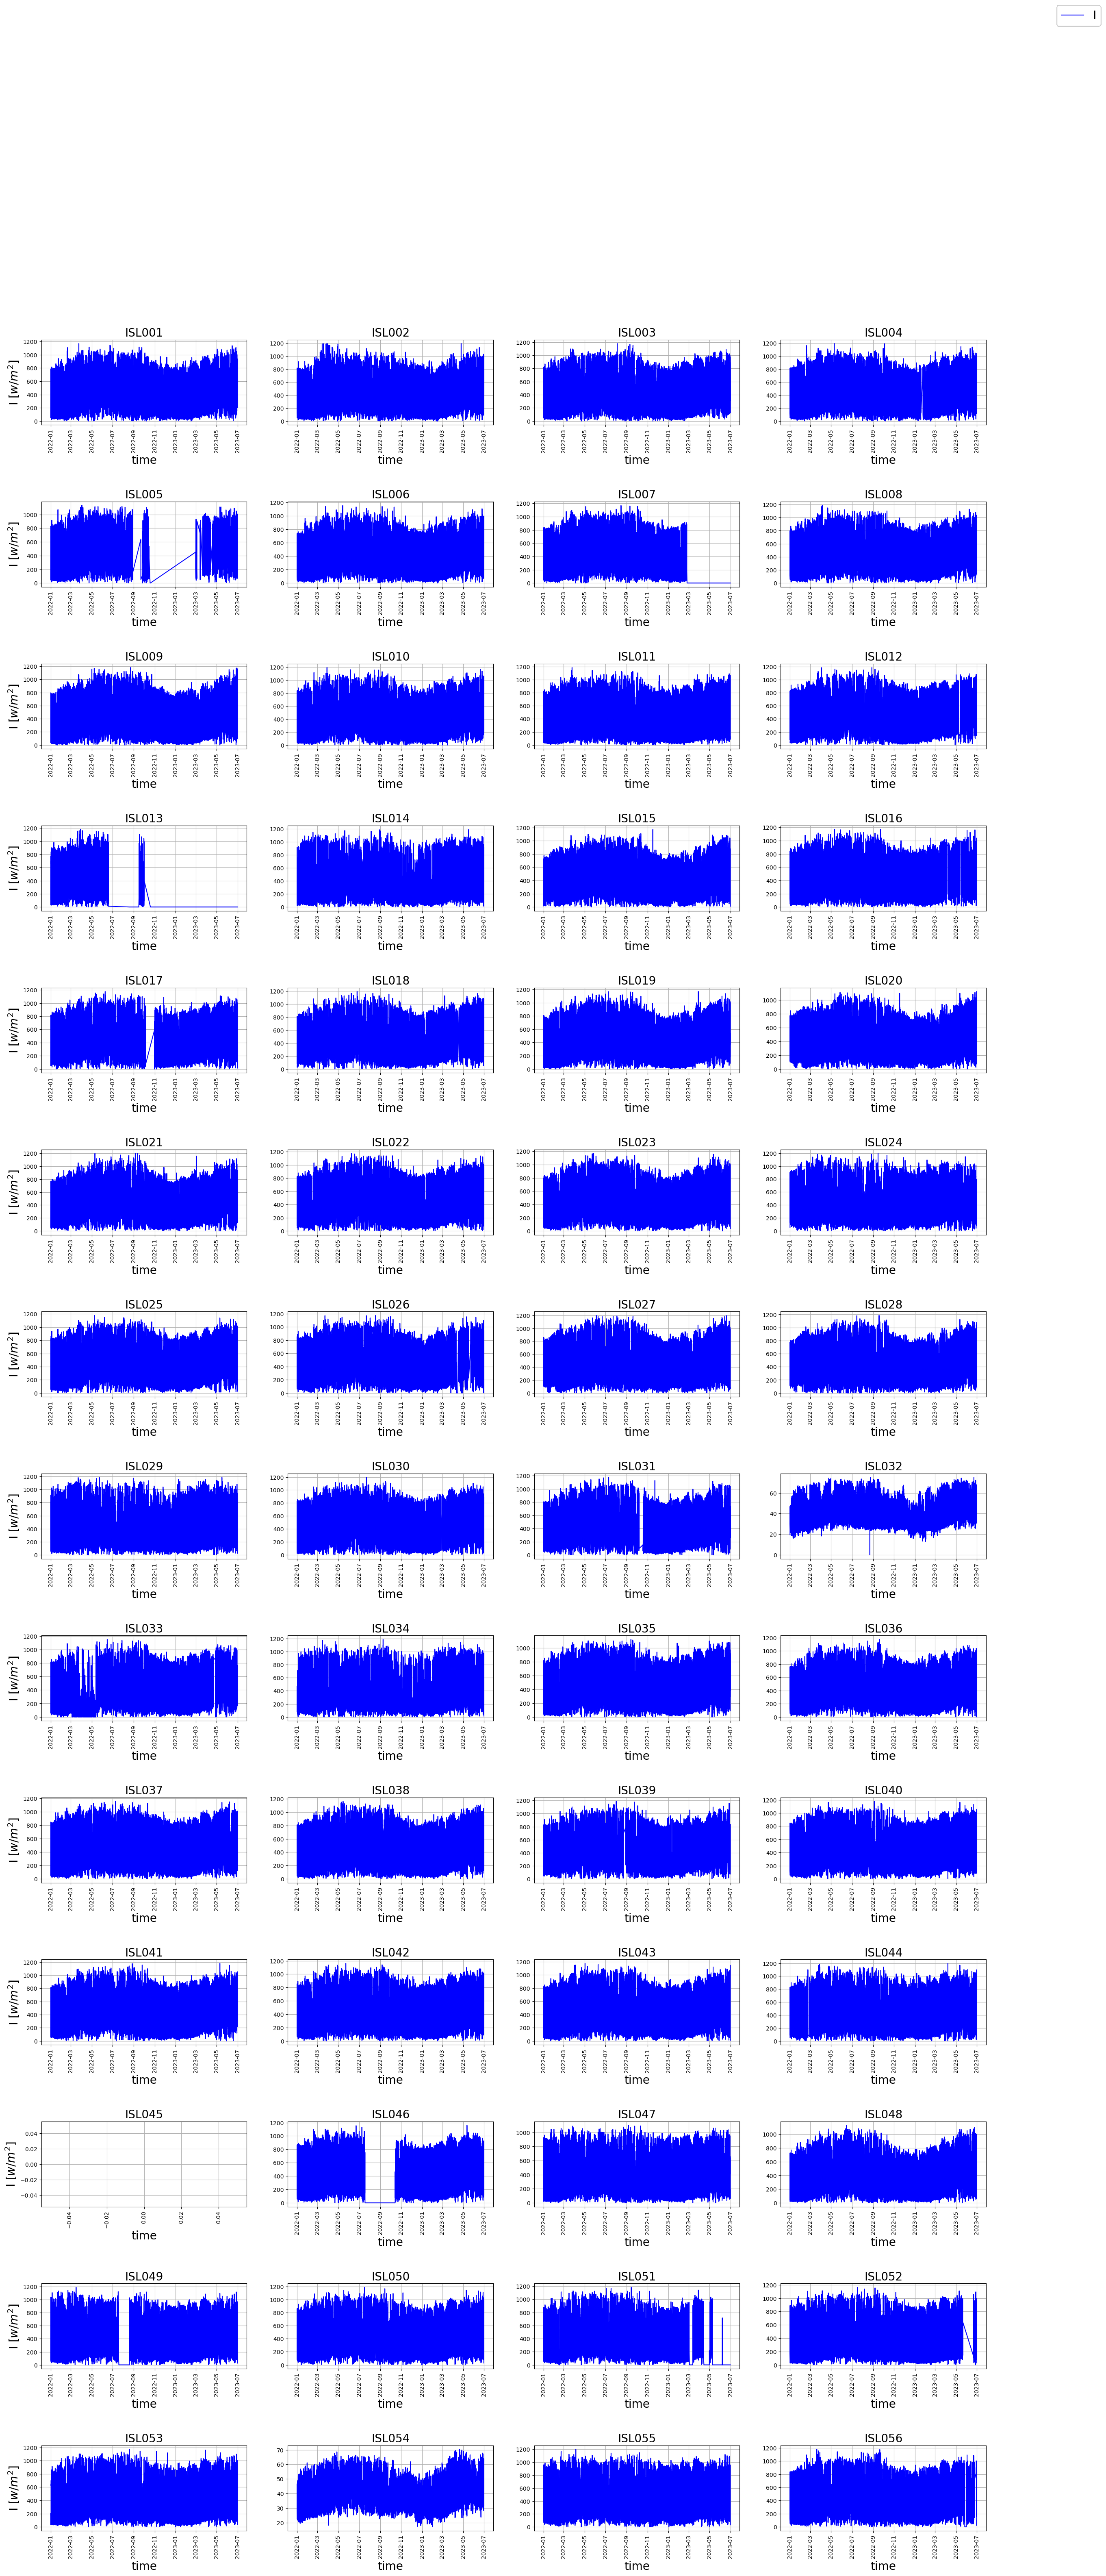

In [86]:
nrow = 14
ncol = 4
####################################
fig, ax = plt.subplots(nrow,ncol, figsize=(30,70))
ax = ax.reshape(1,-1)[0]
for k in range(len(ax)):
    plt.subplot(nrow, ncol, k+1)
    ee1 = measurment_GHI[measurment_GHI.site_name == plant.site_name[k]]
    l1 = plt.plot(ee1.I, '-', color = 'blue')
    if k%4 == 0:
        plt.ylabel(r'I $[w/m^2]$', fontsize=20)
    plt.xticks(rotation = 'vertical');
    plt.title(plant.site_name[k] ,fontsize=20)
    plt.xlabel('time',fontsize=20)
    plt.grid(True)
    plt.subplots_adjust(hspace=0.9)
    fig.legend(l1, labels=['I'],fontsize=20);
plt.show()

In [76]:
##Old data (mearsurment GHI in senior project)

# measurment_GHI = pd.read_csv('/Users/khunnoot/Desktop/year4/senior_project/solarmap_project/clear-sky-detection/ims_cleaned.csv',
#            parse_dates=['Datetime'])
# measurment_GHI.rename(columns = {'ims_wpm2':'I'}, inplace = True)
# measurment_GHI = measurment_GHI.merge(plant[['site_name','lat','lng','alt']], on = 'site_name', how = 'left')
# measurment_GHI.set_index('Datetime', inplace = True)
# measurment_GHI['zna'] = calsolar.cal_dzna(measurment_GHI, measurment_GHI.lat.values, measurment_GHI.lng.values)
# measurment_GHI['czna'] = np.cos(measurment_GHI.zna * np.pi / 180)
# measurment_GHI['AM'] = calsolar.cal_dairmass(measurment_GHI, measurment_GHI.lat.values, measurment_GHI.lng.values)
# measurment_GHI['Iclr'] = calsolar.cal_dclearsky(measurment_GHI, measurment_GHI.lat.values, 
#                                                 measurment_GHI.lng.values, measurment_GHI.alt.values)
# measurment_GHI['k'] = measurment_GHI.I/measurment_GHI.Iclr
# measurment_GHI['date'] = measurment_GHI.index.date
# measurment_GHI.replace([np.inf, -np.inf], np.NaN, inplace=True)
# measurment_GHI.dropna(inplace = True)


# Calculate cosine similirality in each site

    Calculate cosine similarity with input is df_site : contain datetime_index and measurment GHI, 
    threshold k and percentage of the point that greater than theshold k

In [65]:
def cosine_similarity(df_site, threshold_k, percent_majority) :
    date = [str(d) for d in df_site.groupby(by = df_site.index.date).mean().index]
    df_clear = []
    for k in range(len(date)) :
        count = 0
        ee1 = df_site.loc[date[k]]
        b = np.where(ee1.k > threshold_k , 1, 0)
        percent = b.sum()/len(ee1)    
        
        if percent > percent_majority :
            I = ee1['I'].values**2
            Iclr = ee1['Iclr'].values**2
            IIclr = ee1['I'].values * ee1['Iclr'].values
            cosine = IIclr.sum()/(I.sum() * Iclr.sum())**0.5
            df_clear.append({'date' : date[k], 'cosine' : cosine}) 
            
    similarity = pd.DataFrame(df_clear).sort_values(by = 'cosine' , ascending = False)
    
    return similarity

# visualize in each site

In [124]:
site = 1
threshold_k = 0.95
percent_majority = 0.8

df_site = measurment_GHI[(measurment_GHI.zna < 85) & (measurment_GHI.site_name == plant.site_name[site-1])]
cosine_site = cosine_similarity(df_site, threshold_k = threshold_k, percent_majority = percent_majority)
cosine_site

,date,cosine
61,2023-04-03,0.999612
57,2023-02-26,0.999575
56,2023-02-23,0.999565
63,2023-05-06,0.999541
64,2023-05-07,0.999474
...,...,...
45,2022-12-30,0.995315
43,2022-12-28,0.994860
33,2022-11-03,0.994702
14,2022-01-29,0.994530


/var/folders/k4/2flb1pz9447c85n88k4_n8jm0000gn/T/ipykernel_86550/389629667.py:28: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(l1, labels=['I','Iclr'],fontsize=20);


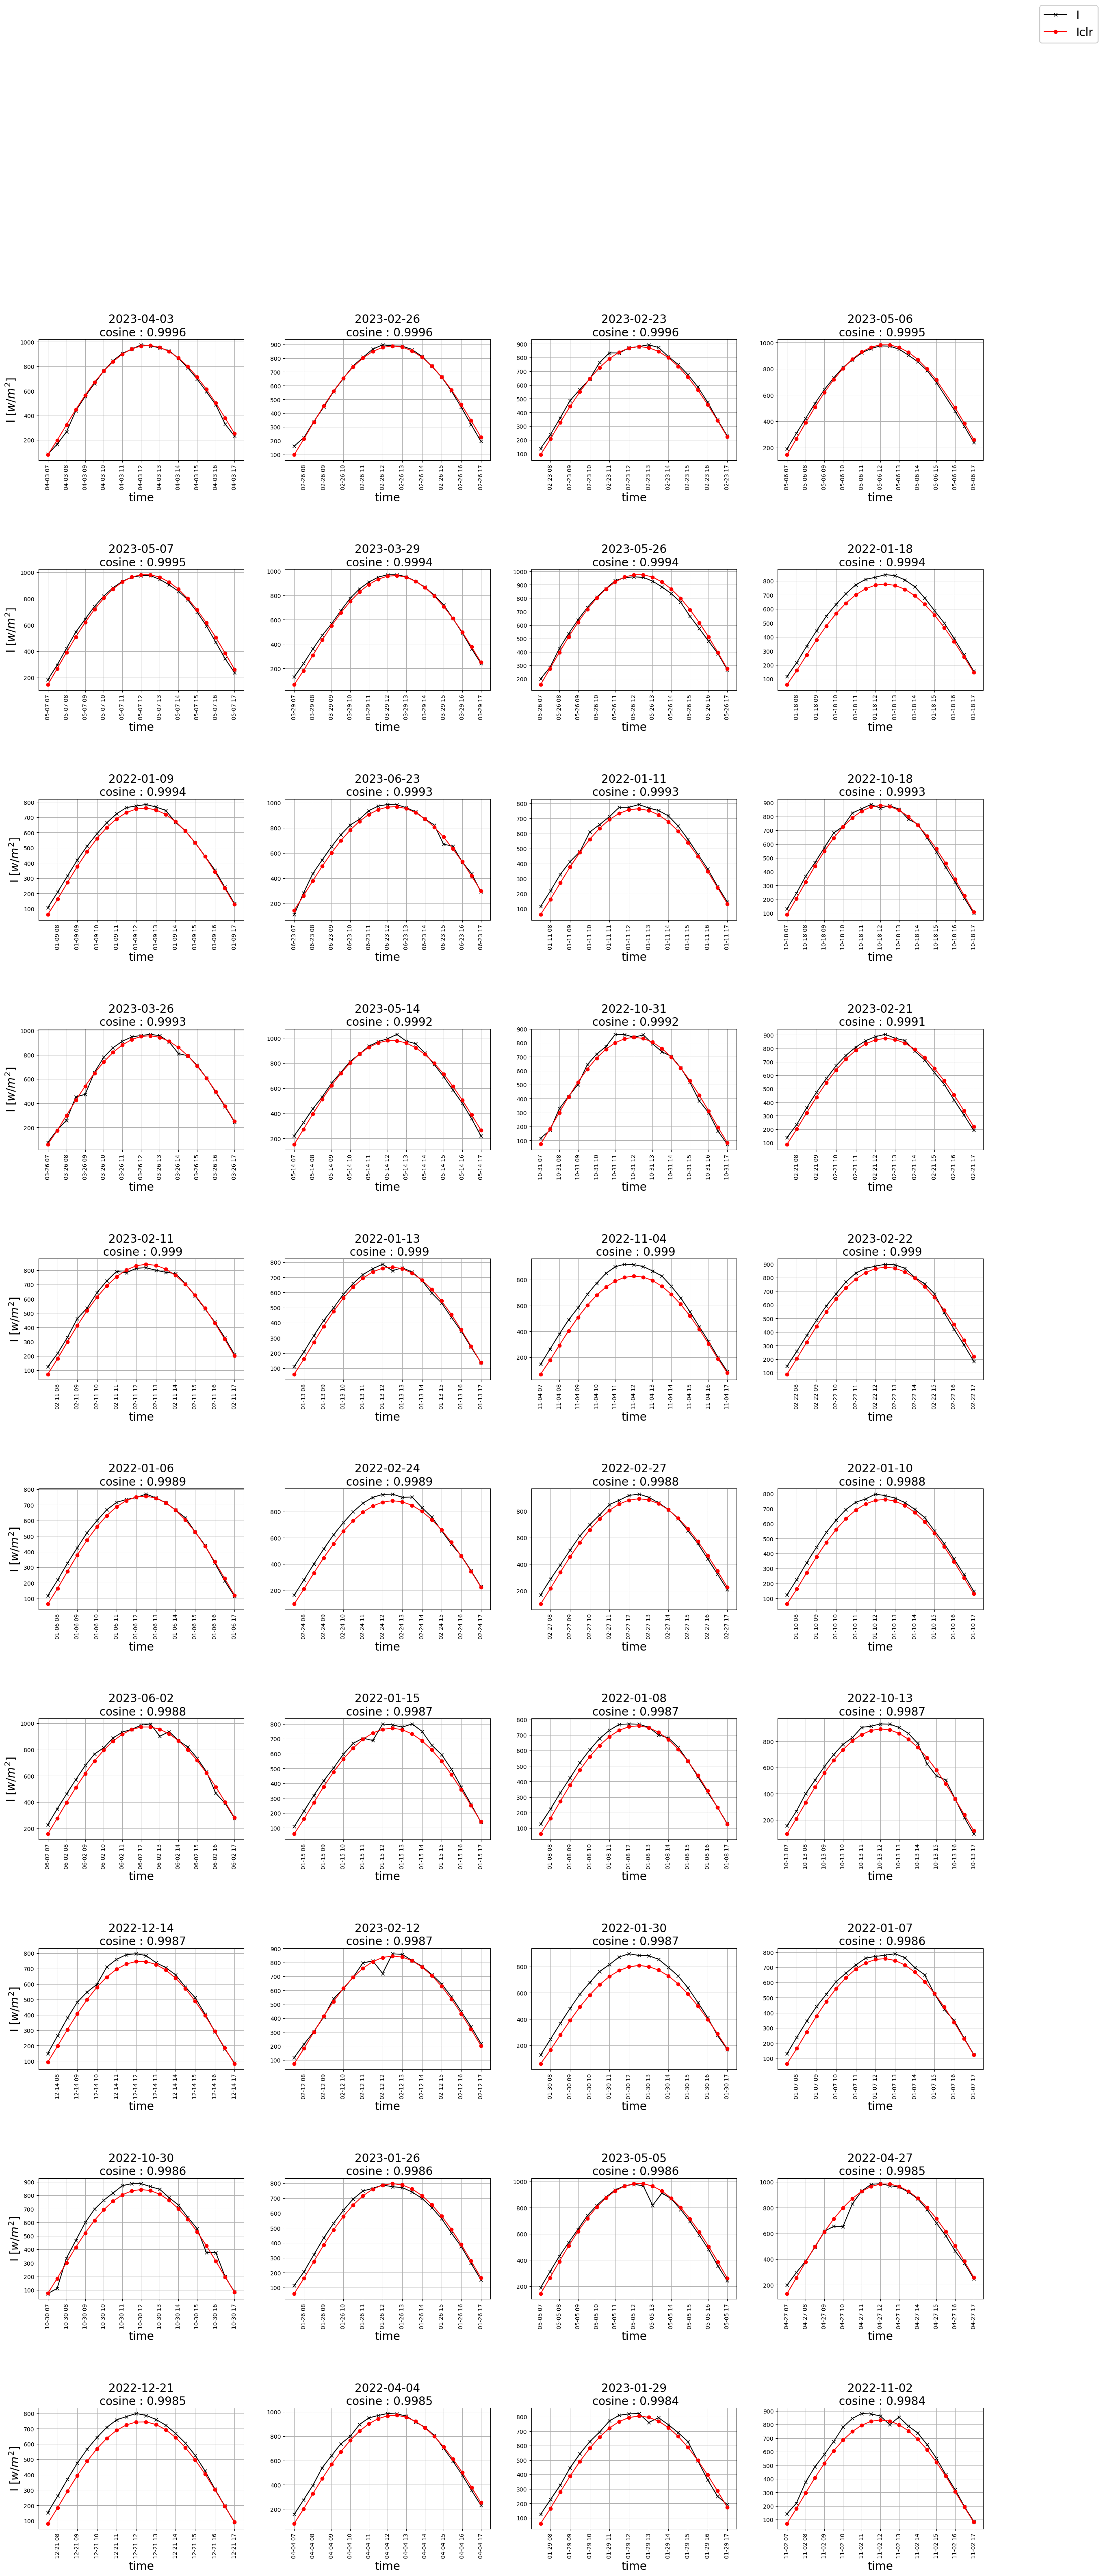

In [120]:
#visualize the clear-sky days that detect by cosine_similarity
clear_date = [str(d) for d in cosine_site.date]
cosine = [ d for d in cosine_site.cosine]

# nrow = int(len(cosine_site)/4)
nrow = 10
ncol = 4
name_model = ['Iclr']
color=['red']

####################################
fig, ax = plt.subplots(nrow,ncol, figsize=(30,70))
ax = ax.reshape(1,-1)[0]
for k in range(len(ax)):
    plt.subplot(nrow, ncol, k+1)
    ee1 = df_site.loc[clear_date[k]]
    l1 = plt.plot(ee1.I, '-x', color = 'black')
    for e in range(len(name_model)):
        l2 = plt.plot(ee1[name_model[e]], '-o', color =color[e])
    
    if k%4 == 0:
        plt.ylabel(r'I $[w/m^2]$', fontsize=20)
    plt.xticks(rotation = 'vertical');
    cos = round(cosine[k],4)
    plt.title(clear_date[k] + '\n cosine : '+ str(cos),fontsize=20)
    plt.xlabel('time',fontsize=20)
    plt.grid(True)
    plt.subplots_adjust(hspace=0.9)
    fig.legend(l1, labels=['I','Iclr'],fontsize=20);

In [123]:
#Calculate TL by using linear regression.

site = 10
threshold_k = 0.95
percent_majority = 0.8
number_clearday = 20 # the day that clear-sky all day setting by visualize in time-series plot

df_site = measurment_GHI[(measurment_GHI.zna < 85) & (measurment_GHI.site_name == plant.site_name[site-1])]
cosine_site = cosine_similarity(df_site, threshold_k = threshold_k, percent_majority = percent_majority)
clearday = cosine_site[:number_clearday-1].copy()

d = [str(d) for d in clearday.date]
df = pd.DataFrame()
for k in range(len(d)):
    df = pd.concat([df,df_site.loc[d[k]]])

df = df[df.I > 0]
I0 = 1366.1
h = plant.alt[site-1]
f1 = math.exp(-h/8000);
f2 = math.exp(-h/1250);
a1 = (h*5.09e-5) + 0.868;
a2 = (h*3.92e-5) + 0.0387;
df['y'] =  (f1 - f2)*a2*df['AM'] + (np.log(df['I'] / (a1 * I0 * df['czna'])))
df['x'] = - a2 * f2 * df['AM']

model = LinearRegression()
model.fit(df.x.values.reshape(-1, 1) , df.y.values)
TL = model.coef_[0]
print('TL = ', TL)
# df.plot.scatter(x='x', y='y', c='DarkBlue')

TL =  2.7279003396190165


# Calculate TL all site

In [66]:
def clearsky_detection(df, threshold_k, percent_majority, number_clearday) :
    TL_list = []
    TL_df = pd.DataFrame()
    for i in range(56):
        df_site = measurment_GHI[(measurment_GHI.zna < 85) & (measurment_GHI.site_name == plant.site_name[i])]
#         if i == 31: # site ISL032 have usable GHI in 2022-02 - 2022-05-1
#             df_site = df_site.loc['2022-02-01':'2022-05-01'] 

        if i == 31 or i == 44 or i == 53: # site ISL045 don't have GHI and GHI in ISL045/032 is range (20-70 W/m2)
            TL_list.append({'site_name':plant.site_name[i], 'lat' : plant.lat[i], 'lon' : plant.lng[i], 'TL' : 'NaN'})
            pass
        else :
            similarity = cosine_similarity(df_site, threshold_k, percent_majority)
            clearday = similarity[:number_clearday-1].copy()
            d = [str(d) for d in clearday.date]
            df = pd.DataFrame()
            for k in range(len(d)):
                df = pd.concat([df,df_site.loc[d[k]]])
            df = df[df.I > 0]
            I0 = 1366.1
            h = plant.alt[0]
            f1 = math.exp(-h/8000);
            f2 = math.exp(-h/1250);
            a1 = (h*5.09e-5) + 0.868;
            a2 = (h*3.92e-5) + 0.0387;
            df['y']= (f1 - f2)*a2*df['AM'] + np.log(df['I'] / (a1 * I0 * df['czna']))
            df['x']= - a2 * f2 * df['AM']

            model = LinearRegression()
            model.fit(df.x.values.reshape(-1, 1) , df.y.values)
            TL = model.coef_[0]
            TL_list.append({'site_name':plant.site_name[i], 'lat' : plant.lat[i], 'lon' : plant.lng[i], 
                            'alt' : plant.lat[i], 'criterion_pass' : len(similarity), 'TL' : TL})
            
            TL_df = pd.concat([TL_df, df])
    TL_all = LinearRegression()
    TL_all.fit(TL_df.x.values.reshape(-1, 1) , TL_df.y.values)
    TL56site = TL_all.coef_[0]

    df_TL = pd.DataFrame(TL_list)
    return df_TL, TL56site
    

In [125]:
df_TL, TL56site = clearsky_detection(measurment_GHI, 
                                     threshold_k = 0.9, 
                                     percent_majority = 0.8, 
                                     number_clearday = 20)
print('TL all 56 sites = ',TL56site)
df_TL

TL all 56 sites =  2.7229528430919903


,site_name,lat,lon,alt,criterion_pass,TL
0,ISL001,14.005230,100.519403,14.005230,102.0,3.180888
1,ISL002,13.706500,100.281200,13.706500,105.0,2.737202
2,ISL003,13.653800,100.522300,13.653800,117.0,3.286698
3,ISL004,13.635425,100.632181,13.635425,134.0,2.984169
4,ISL005,13.692800,100.897200,13.692800,90.0,2.803597
5,ISL006,13.808630,100.439000,13.808630,84.0,3.03174
6,ISL007,15.635300,100.476300,15.635300,127.0,2.735892
7,ISL008,14.306600,100.611600,14.306600,134.0,2.957482
8,ISL009,18.128400,100.144000,18.128400,156.0,2.657454
9,ISL010,13.808060,100.447297,13.808060,110.0,2.764081


In [127]:
import folium
from folium.plugins import HeatMap, HeatMapWithTime

df = df_TL
df.dropna(inplace = True)

# Create a map centered on the first coordinate (you can adjust the coordinates and zoom level)
map_center = [df['lat'].iloc[45], df['lon'].iloc[45]]
map_zoom = 14
map_obj = folium.Map(location=map_center, zoom_start=map_zoom)

# Add markers for each coordinate with the TL value as a popup
for index, row in df.iterrows():
    latitude, longitude, tl_value, site = row['lat'], row['lon'], row['TL'], row['site_name']
    popup_text = f"Site: {site} " f"TL: {tl_value}"
    folium.Marker(location=[latitude, longitude], popup=popup_text).add_to(map_obj)

# Create a list of (latitude, longitude, weight) tuples for the HeatMap
heatmap_data = [(row['lat'], row['lon'], row['TL']) for index, row in df.iterrows()]

# Add HeatMap layer to the map
HeatMap(heatmap_data).add_to(map_obj)


# map_obj.save("map_with_markers_and_heatmap.html")
map_obj
